# Filtering of DLSU-D Related Unofficial Freedom Wall Posts Using Logistic Regression

## Import the necessary libraries

Let's import the necessary libraries to create our prototype model:

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

nltk.download('stopwords')

/home/mayo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /home/mayo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading dataset

Let's load our CSV file and turn them into Panda's DataFrame object:

In [2]:
df = pd.read_csv('dataset/csv/posts.csv')
df.head()

,date,post_text,label
0,2023-09-13 18:37:49,ok😂😂😂🫵,0
1,2023-09-13 15:09:05,"hello! keeb peeps sa ud, baka gusto niyo handl...",0
2,2023-09-13 15:08:03,Hello po may possible po kaya na mag oopen po ...,1
3,2023-09-13 15:07:03,Baka meron naka pulot ng id sa jfh building ;),0
4,2023-09-13 15:06:04,Kung sino man yung guy na nakabunggo ko kasi l...,0


## Separate posts based on their label

Let's separate posts that is concerned with the university and non-concerned.

In [3]:
related = df[df['label'] == 1]['post_text'].values
non_related = df[df['label'] == 0]['post_text'].values

print('Related DLSU-D posts length:', len(related))
print('Non DLSU-D related posts length:', len(non_related))

print('\nDLSU-D related posts examples:')
for i in range(3):
    print(f'\t{i + 1}. {related[i][:200]}...')

print('\nNon DLSU-D related posts examples:')
for j in range(3):
    print(f'\t{j + 1}. {non_related[j][:200]}...')

Related DLSU-D posts length: 285
Non DLSU-D related posts length: 1204

DLSU-D related posts examples:
	1. Hello po may possible po kaya na mag oopen po ulit yung admission for scholarship sa UD?...
	2. ADMIN PA POST!

Small rant lang! San ba pwede mag reklamo ng profs na puro pagawa pero walang proper lesson and puro readings lang? Ang sabi, you read, I read, we lecture. Ang nangyayari ay, I read, N...
	3. angaass may pa-esports convention yung cscs!!!!! PWEAASEE open niyo to all colleges baka naman OTL...

Non DLSU-D related posts examples:
	1. ok😂😂😂🫵...
	2. hello! keeb peeps sa ud, baka gusto niyo handlubed harvested 81 pieces cidoo matte linear switches from cidoo v87 for 1700 or can go lower to 1600

creamy sound and more on the poppy side, can be thoc...
	3. Baka meron naka pulot ng id sa jfh building ;)...


## Separate training data from test data

We will use the 80% of data based on their class to use for our training and the 20% or our testing. This will help us to check the accuracy of our model better.

In [4]:
related_training_count = int(len(related) * 0.8)
non_related_training_count = int(len(non_related) * 0.8)

related_train = related[:related_training_count]
related_test = related[related_training_count:]
non_related_train = non_related[:non_related_training_count]
non_related_test = non_related[non_related_training_count:]

train_x = np.append(related_train, non_related_train, axis=0)
test_x = np.append(related_test, non_related_test, axis=0)
train_y = np.append(np.ones((len(related_train), 1)), np.zeros((len(non_related_train), 1)), axis=0)
test_y = np.append(np.ones((len(related_test), 1)), np.zeros((len(non_related_test), 1)), axis=0)

print('train_x length:', len(train_x))
print('train_y length:', len(train_y))
print('test_x length:', len(test_x))
print('test_y length:', len(test_y))

train_x length: 1191
train_y length: 1191
test_x length: 298
test_y length: 298


## Natural Language Preprocessing

First, we have to clean our text through the use of preprocessing before extracting features from our text. The steps in preprocessing of text for binary classification is the following:

- removing links, mail addresses, etc.
- tokenizing texts
- lowercasing
- removing punctuations
- removing stopwords
- stemming

In addition, we also have to detect if a given word is filipino word so that we can use a separate stemmer to preprocess them.

Now let's write a function `process_text` to preprocess our text.

In [5]:
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import enchant
from TagalogStemmerPython.TglStemmer import stem_word as stem_filipino
from tl_stopwords import TL_STOP_WORDS as tl_stopwords

def process_text(text):
    '''Preprocess a text and return a token of stem of words that is relevant for feature extraction
    Parameters:
        - text: a string to preprocess
    '''
    en_dict = enchant.Dict("en_US")
    eng_stopwords = stopwords.words('english')
    stemmer = PorterStemmer()
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    
    text = re.sub(r'\b([0-9]*)\b', '', text) # Remove numbers

    text_stems = set()
    
    text_tokens = tokenizer.tokenize(text)
    for token in text_tokens:
        if token not in string.punctuation and token not in eng_stopwords and token not in tl_stopwords:
            text_stems.add(stemmer.stem(token))
            if not en_dict.check(token):
                text_stems.add(stem_filipino(token))
    
    return list(text_stems)

### Testing `process_text`

Let's test our function if it works:

In [6]:
sample_post = train_x[10]
processed = process_text(sample_post)

print(f'Non-processed Text:\n\t-{sample_post}...')
print('\n\nProcessed Text:\n\t-')
print(processed)

Non-processed Text:
	-Sa mga mag aapply for org jan, wag naman kayo mag asta na para kayong hindi dumaan sa hs and shs. Simpleng reading comprehension sa mga publications hindi magawa? Tapos magrereklamo kayo, magpapa bebe kayo sa pagcchat. Marunong ba kayong maging professional? yung totoo lang ha. Nasa DLSUD kayo, hindi high school club ang sasalihan nyo. Yang mga orgs na yan, college orgs man o performing arts group, or yung mga auxiliary orgs, matagal na yang nasa sistema ng Lasalle Dasma. Student leaders ang hinahanap, hindi clout chasers. Kung mag iinquire kayo mag practice na kayo maging formal, umasta kayo as COLLEGE STUDENTS. This is for everyone, wag kayo masyadong demanding jan sa replies, wag nyo pangunahan yung instructions na binibigay sa inyo. STUDENT LEADERS yan, hindi lang yan admin na magrereply sayo agad. INTINDIHIN nyo sila and UMINTINDI kayo ng INSTRUCTIONS....


Processed Text:
	-
['totoo', 'naman', 'asta', 'umasta', 'demand', 'jan', 'ba', 'colleg', 'admin', 'prac

## Building frequencies

Now, we have to build frequencies of how many times a words appeared based on their corresponding labels (related or non-related). For this, we will use the python dictionary to allow for faster searching. Let's build a function `build_frequencies` where it will accept a list of texts and list of labels as parameters. 

The function will return a dictionary with keys `(word, label)` and their corresponding counts based on how many times they appeared on the entire dataset based on their corresponding label as values.

In [7]:
def build_frequencies(texts, ys):
    '''Return a dictionary with tuple of (word, label) as keys
    and values are how many times a word appeared on the dataset
    based on their corresponding label.
    
    Parameters:
        - xlist: a list of texts
        - ylist: a list of labels corresponding to texts
    '''
    textslist = np.squeeze(texts).tolist()
    labels = np.squeeze(ys).tolist()
    
    freqs = {}
    for label, text in zip(labels, textslist):
        for word in process_text(text):
            key = (word, label)
            freqs[key] = freqs.get(key, 0) + 1
    
    return freqs

### Testing `build_frequencies`

Let's test the function with just one item list to check if it is working:

In [8]:
test_freq_x = [related_train[5], non_related_train[5]]
test_freq_y = [1, 0]

print(build_frequencies(test_freq_x, test_freq_y))

{('', 1): 1, ('sana', 1): 1, ('far', 1): 1, ('totoo', 1): 1, ('rn', 1): 1, ('dami', 1): 1, ('sabi', 1): 1, ('iba-iba', 1): 1, ('naman', 1): 1, ('yan', 1): 1, ('yung', 1): 1, ('school', 1): 1, ('aral', 1): 1, ('ako', 1): 1, ('nauumay', 1): 1, ('wala', 1): 1, ('tuturo', 1): 1, ('ayos', 1): 1, ('least', 1): 1, ('lang', 1): 1, ('librari', 1): 1, ('swerte', 1): 1, ('terror', 1): 1, ('facil', 1): 1, ('ba', 1): 1, ('saya', 1): 1, ('nga', 1): 1, ('maayo', 1): 1, ('sinasabi', 1): 1, ('naiini', 1): 1, ('ceat', 1): 1, ('bihirang', 1): 1, ('tumambay', 1): 1, ('swert', 1): 1, ('tapo', 1): 1, ('umay', 1): 1, ('assess', 1): 1, ('binabaha', 1): 1, ('ahaha', 1): 1, ('froshi', 1): 1, ('bihira', 1): 1, ('sumipot', 1): 1, ('baka', 1): 1, ('ewan', 1): 1, ('sipot', 1): 1, ('prof', 1): 1, (':)', 1): 1, ('medyo', 1): 1, ('tapos', 1): 1, ('inis', 1): 1, ('iba', 1): 1, ('classroom', 1): 1, ('mag-ar', 1): 1, ('magtuloy-tuloy', 1): 1, ('nag', 1): 1, ('roshie', 1): 1, ('turo', 1): 1, ('akong', 1): 1, ('hindi', 1):

Now that it works, let's test it on our whole training set

In [9]:
freqs = build_frequencies(train_x, train_y)

print('Total length of frequencies dictionary:', len(freqs))

Total length of frequencies dictionary: 9527


## Extracting features

Now, let's extract the features of the post by writing function `extract_features`. The function will return a list with 3 elements: 

- the first element is the bias (which has value 1)
- the second element is the number of times where the words of the text appear in frequencies dictionary with DLSU-D related post labels
- the last element is the number of times where the words of the text appear in frequencies dictionary with non DLSU-D related post labels

In [10]:
def extract_features(text, freqs):
    '''Extract features from preprocessed text.
    Parameters:
        - text: a string, particularly a mail
        - freqs: a dictionary with a using key (word, label) which contains 
        counts or how many times a word appeard based on label
    '''
    tokens = process_text(text)
    
    features = np.zeros(3)
    features[0] = 1
    
    for word in tokens:
        features[1] += freqs.get((word, 1.0), 0)
        features[2] += freqs.get((word, 0), 0)
        
    features = features[None, :] # add batch dimension for further processing
    assert(features.shape == (1, 3))
    return features

### Testing `extract_features`

Now let's test the function with the previous sample post we tested to check that it works correctly:

In [11]:
print(f'Sample Post:\n\t-{sample_post}...')
print('\nFeature:', extract_features(sample_post, freqs))

Sample Post:
	-Sa mga mag aapply for org jan, wag naman kayo mag asta na para kayong hindi dumaan sa hs and shs. Simpleng reading comprehension sa mga publications hindi magawa? Tapos magrereklamo kayo, magpapa bebe kayo sa pagcchat. Marunong ba kayong maging professional? yung totoo lang ha. Nasa DLSUD kayo, hindi high school club ang sasalihan nyo. Yang mga orgs na yan, college orgs man o performing arts group, or yung mga auxiliary orgs, matagal na yang nasa sistema ng Lasalle Dasma. Student leaders ang hinahanap, hindi clout chasers. Kung mag iinquire kayo mag practice na kayo maging formal, umasta kayo as COLLEGE STUDENTS. This is for everyone, wag kayo masyadong demanding jan sa replies, wag nyo pangunahan yung instructions na binibigay sa inyo. STUDENT LEADERS yan, hindi lang yan admin na magrereply sayo agad. INTINDIHIN nyo sila and UMINTINDI kayo ng INSTRUCTIONS....

Feature: [[1.000e+00 9.700e+02 1.816e+03]]


## Collect features and visualize

Let's collect the features of our data and visualize them with scatter plot.

In [12]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)

Y = train_y

Text(0, 0.5, 'Spams')

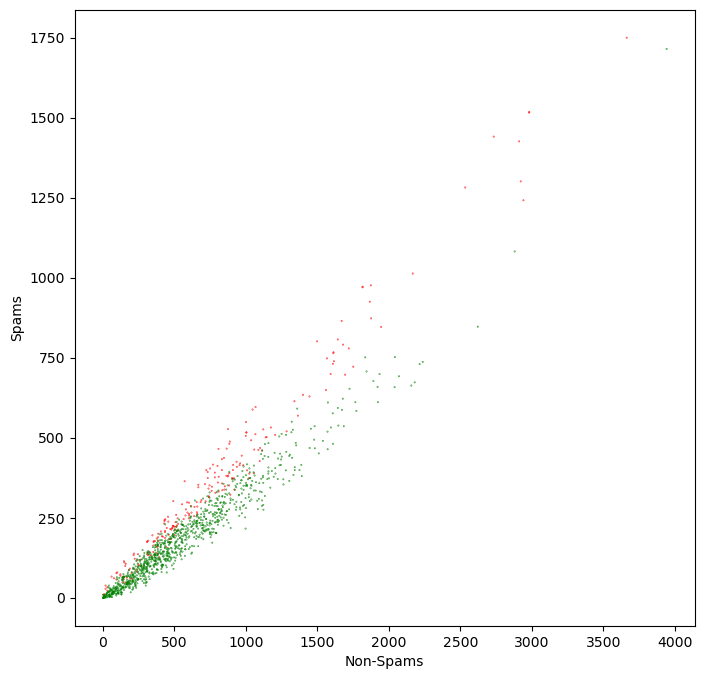

In [13]:
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['green', 'red']

ax.scatter(X[:, 2], X[:, 1], c=[colors[int(np.squeeze(k))] for k in Y], s = 0.1) 
plt.xlabel('Non-Spams')
plt.ylabel('Spams')

As you can see from the figure, there are quite distinctions for words that appear in DLSU-D related Freedom Wall posts and non DLSU-D related Freedom Wall posts.

## Sigmoid Function

We will use the sigmoid function to predict our text in which it will return number between 0 and 1. The formula for sigmoid is as follows:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Let's refer to z as 'logits'. We can calculate the logits in python by applying **dot product** to vectors $\theta$ and $x$:

$$z = \theta x$$

The shape of $z$ will be `(m, 1)` and applying the sigmoid function $h(z)$ will also return $h$ with shape `(m, 1)`
* $m$ is the number of training samples

Now let's implement a function `sigmoid` to calculate the sigmoid function.

In [14]:
def sigmoid(z):
    '''Return the sigmoid activation of logit
    Parameter:
        - z: a logit, calculated by multiplying vector theta and vector x
    '''
    h = 1 / (1 + np.exp(-z))
    return h

Text(0.5, 1.0, 'Sigmoid Function')

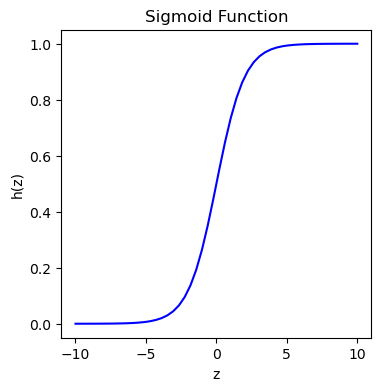

In [15]:
fg, ax = plt.subplots(figsize = (4, 4))

zs = np.linspace(-10, 10)

ax.plot(zs, [sigmoid(z) for z in zs], color='blue')
plt.xlabel('z')
plt.ylabel('h(z)')
plt.title('Sigmoid Function')

## Cost Function

The cost function will help us calculate the loss of prediction, or how well a machine learning model performs by finding the difference between predicted and actual outputs. Here is the formula for the cost function in a logistic regression:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$: the number of training examples
* $y^{(i)}$: the true label of training example 'i'
* $h(z^{(i)})$: the sigmoid function or model's prediction for training example 'i'

We can perform matrix multiplication to calculate the cost function which will give us this formula:

$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* $y$ and $h$ both have shape (m, 1), so we have to transpose the vector $y$ to the left to perform matrix multiplication with dot product
* $z$ is calculated by multiplying the feature matrix $x$ with the weight vector 'theta'. $z = x\theta$
* $h$ is calculated with applying sigmoid to each element 'z'. It has a shape of (m, 1)

## Gradient Descent

We will use gradient descent to train our model. The gradient descent will take the derivative of the cost function which is the gradient. With the help of gradient descent, over time we will reduce the cost in which it will make our model more accurate. The learning rate or $\alpha$ is also crucial and we should pick the right value in order for our gradient descent to not step too much or else we will pass over the global minima of the cost function.

Gradient descent will return an improved parameter $\theta$ that will be helpful in making more accurate prediction.

The formula for the gradient descent is as follows:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$

$\nabla_{\theta_j}J(\theta)$ is the derivative of the cost function. By implementing this with python, we can use the following formula:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$
* We have to transpose $x$ on the left because it's dimension is (m, n+1). Both $h$ and $y$ have shape (m, 1). Then perform matrix operation.

Now let's implement function `gradient_descent`:

In [16]:
def gradient_descent(x, y, theta, alpha, iter_count):
    '''Perform gradient descent over n number of iterations.
    Parameters:
        - x: list of features
        - y: list of labels
        - theta: weight parameters
        - alpha: learning rate
        - iter_count: number of iterations
    '''
    m = np.shape(x)[0]
    
    for i in range(0, iter_count):
        z = np.dot(x, theta)
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1.0 * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))) / m
        # print(f'#{i} Cost: {float(J)}')

        # update the weights theta
        theta = theta - alpha / m * np.dot(x.T, h - y)
    
    J = float(np.squeeze(J))
    return J, theta

## Training logistic regression model

We already had extracted the features of x and also we have the list of true labels y. Now let's train our model to get optimal parameters that we will use to predict our testing dataset.

In [17]:
J, theta = gradient_descent(X, Y, np.zeros((3, 1)), 1e-5, 5000)
print(f'Post-training cost: {J}')
print(f'Post-training parameters or weights: {[round(t, 8) for t in np.squeeze(theta)]}')

Post-training cost: 0.27961192722152284
Post-training parameters or weights: [-0.00368053, 0.06976016, -0.02974936]


## Predicting post

Now is the time to test our logistic regression and test inputs the model has not seen yet.
Let's create a function called `predict'

In [18]:
def predict(post, freqs, theta):
    '''Predict a post and return their classification score.
    Parameters:
        - post: a string, particularly a post
        - freqs: a dictionary with a using key (word, label) which contains 
        counts or how many times a word appeard based on label
        - theta: weight parameters
    '''
    x = extract_features(post, freqs)
    z = np.dot(x, theta)
    y_pred = sigmoid(z)
    return y_pred

In [28]:
post = test_x[5]
predicted = np.squeeze(predict(post, freqs, theta))
print(f'post: {post}...')
print(f'true label: {np.squeeze(test_y)[2]}')
print(f'score: {predicted}')

post: I'm from BIO31.

Sana urgent din ma-post. I'm calling the attention of all my blockmates.

I'm a full scholar here and right now, my grade in Biophysics Lec is 56.00, which means matatanggal na po lahat ng scholarship ko inside and outside the university.

Siguro iniisip ninyo, "Bakit ka pa nag-La Salle, wala naman pala kayong pera?".

If only ISee more knew na may ganitong prof pala, sana nga po hindi na lang ako nag-La Salle Dasma.

I know that from the past years, hindi tayo masyadong nagkakaisa, pero please pwede ninyo ba akong tulungan? :'( Please, guys, nagmamakaawa ako na sana samahan ninyo akong kumilos regarding this.

And to those who are reading this, Idk what to do anymore hindi naman po ako bobo sa math.

And for how many years, ako po nagpapaaral sa sarili ko through scholarship that's why I don't know paano nangyari ito.
Sana naging considerate yung prof kasi lahat kami it's either nasa line of 5 and saktong 60 lang ang grade.

There's clearly a problem sa prof....

## Testing logistic regression

Let's test our logistic regression and calculate its accuracy

In [20]:
pred_y = []

for post in test_x:
    y_hat = predict(post, freqs, theta)
    
    if y_hat > 0.5:
        pred_y.append(1.0)
    else:
        pred_y.append(0)

In [21]:
print('Precision Score:', precision_score(test_y, pred_y, average='micro'))

Precision Score: 0.8221476510067114


In [22]:
print('Recall Score:', recall_score(test_y, pred_y, average='micro'))

Recall Score: 0.8221476510067114


In [23]:
print('F1 Score:', f1_score(test_y, pred_y, average='micro'))

F1 Score: 0.8221476510067114


In [24]:
print('Classification Report:\n')
print(classification_report(test_y, pred_y))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       241
         1.0       0.54      0.49      0.51        57

    accuracy                           0.82       298
   macro avg       0.71      0.70      0.70       298
weighted avg       0.82      0.82      0.82       298



In [25]:
print('Confusion Matrix:\n')
print(confusion_matrix(test_y, pred_y))

Confusion Matrix:

[[217  24]
 [ 29  28]]
